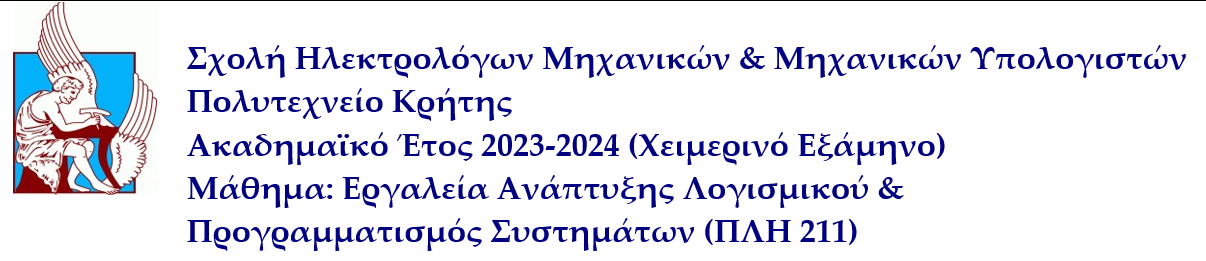

# Εργασία 1 - Θέμα: Ανάπτυξη Λογισμικού Aggregative News Analyzer

---
⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰
# ΔΕΝ προχωράμε παρακάτω σε αυτό το notebook αν δεν έχουμε διαβάσει και είμαστε έτοιμοι να εφαρμόσουμε ακριβώς τις οδηγίες που διανέμονται μαζί με αυτή την εργασία στο PLH211_Project1_2023_2024_Directions.docx.
---
⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰⏰

<font color='red'> Στα πλαίσια της εργασίας δεν μπορείτε να υποθέσετε ότι τα news και άρα τα αρχεία που σας δίδονται δεν αλλάζουν ποτέ. Το αρχείο με τα news θεωρείται μεταβλητό καθώς σε ένα πραγματικό σενάριο τα news ανανεώνονται σε τακτά χρονικά διαστήματα. Άρα δεν μπορείτε να προ-υπολογίσετε το Jaccard Index και όσα άλλα ζητούνται μόνο μια φορά και να τα σώσετε μια μόνο φορά σε αρχείο.</font>  

# Development Phase

## ⏩ Κώδικας Development Phase
Γράψτε στο παρακάτω code cell όλο τον κώδικα που υλοποιεί τον Aggregative News Analyzer σας.

In [12]:
import json
from openpyxl import Workbook


def parse_categories_per_document(filepath):
    """
    Parses the qrels file and returns a dictionary mapping each document ID to a list of categories.

    :param filepath: Path to the qrels file
    :return: Dictionary with document IDs as keys and lists of categories as values
    """

    categories_per_document = {}

    with open(filepath, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 3:
                category, document_id, _ = parts
                if document_id not in categories_per_document:
                    categories_per_document[document_id] = []
                categories_per_document[document_id].append(category)

    return categories_per_document


def parse_terms_in_documents(*filepaths):
    """
    Parses multiple vectors files and returns a dictionary mapping each document ID to a list of term IDs (ignoring weights).

    :param filepaths: Paths to the vectors files
    :return: Dictionary with document IDs as keys and lists of term IDs as values
    """
    terms_per_document = {}

    for filepath in filepaths:
        with open(filepath, 'r') as file:
            for line in file:
                parts = line.strip().split()
                document_id = parts[0]
                if document_id not in terms_per_document:
                    terms_per_document[document_id] = []
                term_ids = [term.split(':')[0] for term in parts[1:]]  # Extract term id, ignoring the weights
                terms_per_document[document_id].extend(term_ids)  # Combine term IDs from all files

    return terms_per_document


def parse_tid_to_stem(filepath):
    """
    Parses the stem-term-idf map file and returns two dictionaries: one mapping term IDs to stems,
    and another mapping stems to term IDs (ignoring the idf values).

    :param filepath: Path to the stem-term-idf map file
    :return: Tuple of two dictionaries (term_id_to_stem, stem_to_term_id)
    """

    term_id_to_stem = {}
    stem_to_term_id = {}

    with open(filepath, 'r', encoding='ISO-8859-1') as file:
        # Skip the first two lines as they are junk data
        next(file)
        next(file)
        for line in file:
            parts = line.strip().split()
            if len(parts) == 3:
                stem, term_id, _ = parts
                term_id_to_stem[term_id] = stem
                stem_to_term_id[stem] = term_id

    return term_id_to_stem, stem_to_term_id

def precompute_doc_sets(terms_per_document, categories_per_document):
    # Precompute DOC(T)
    doc_per_term = {}
    for doc_id, term_ids in terms_per_document.items():
        for term_id in term_ids:
            if term_id not in doc_per_term:
                doc_per_term[term_id] = set()
            doc_per_term[term_id].add(doc_id)

    # Precompute DOC(C)
    doc_per_category = {}
    for doc_id, categories in categories_per_document.items():
        for category in categories:
            if category not in doc_per_category:
                doc_per_category[category] = set()
            doc_per_category[category].add(doc_id)

    return doc_per_term, doc_per_category


def calculate_jaccard_index(doc_per_term, doc_per_category):
    # Initialize Jaccard Index dictionary
    jaccard_index = {}
    # Calculate Jaccard Index without explicitly performing set operations
    for term_id, docs_with_term in doc_per_term.items():
        for category, docs_in_category in doc_per_category.items():
            intersection_size = len(docs_with_term.intersection(docs_in_category))
            union_size = len(docs_with_term) + len(docs_in_category) - intersection_size
            jaccard_index[(term_id, category)] = intersection_size / union_size if union_size else 0
    return jaccard_index


def handle_command(command, jaccard_index, term_id_to_stem_map, stem_to_term_id_map, parsed_terms_in_documents, parsed_categories_per_document):

    command_parts = command.split()
    command_type = command_parts[0]
    if command_type == "@":
        category = command_parts[1]
        k = int(command_parts[2])
        result = show_top_k_stems_for_category(category, k, jaccard_index, term_id_to_stem_map)
        print(result)
    elif command_type == "#":
        stem = command_parts[1]
        k = int(command_parts[2])
        result = show_top_k_categories_for_stem(stem,k,jaccard_index,stem_to_term_id_map)
        print(result)
    elif command_type == "$":
        stem = command_parts[1]
        category = command_parts[2]
        result = show_jaccard_index_for_pair(stem, category, jaccard_index, stem_to_term_id_map)
        print(result)

    elif command_type == "*":
        filename = command_parts[1].rsplit('.', 1)[0]  # Extract the filename without the extension
        filetype = command_parts[1].rsplit('.', 1)[1]  # Extract the extension as filetype
        save_all_pairs(filename, filetype, jaccard_index, term_id_to_stem_map)
        print(f"Data has been saved to {filename}.{filetype}")
    elif command_type == "P":
        doc_id = command_parts[1]
        switch = command_parts[2]
        result = show_stems_or_categories_for_document(doc_id, switch, parsed_terms_in_documents, parsed_categories_per_document, term_id_to_stem_map)
        print(result)

    elif command_type == "C":
        doc_id = command_parts[1]
        switch = command_parts[2]
        count = count_terms_or_categories_for_document(doc_id, switch, parsed_terms_in_documents, parsed_categories_per_document)
        print(count)

    else:
        return "Invalid command."


def show_top_k_stems_for_category(category, k, jaccard_index, term_id_to_stem_map):
    # Convert k to integer in case it's passed as a string
    k = int(k)

    # Filter Jaccard scores for the specified category
    category_scores = {term_id: score for (term_id, cat), score in jaccard_index.items() if cat == category}

    # Sort terms by Jaccard Index in descending order and get the top k
    top_k_terms = sorted(category_scores.items(), key=lambda item: item[1], reverse=True)[:k]

    # Convert term IDs to stems using the term_id_to_stem_map, handling cases where the term ID might not be in the map
    top_k_stems = [(term_id_to_stem_map.get(term_id, "unknown"), score) for term_id, score in top_k_terms]

    return top_k_stems

def show_top_k_categories_for_stem(stem, k, jaccard_index, stem_to_term_id):
    # Convert k to integer in case it's passed as a string
    k = int(k)

    # Retrieve the term_id for the given stem
    term_id = stem_to_term_id.get(stem)

    # If the stem is not found, return an empty list
    if not term_id:
        return []

    # Filter Jaccard scores for the specified term_id
    term_scores = {cat: score for (t_id, cat), score in jaccard_index.items() if t_id == term_id}

    # Sort categories by Jaccard Index in descending order and get the top k
    top_k_categories = sorted(term_scores.items(), key=lambda item: item[1], reverse=True)[:k]

    return top_k_categories

def show_jaccard_index_for_pair(stem, category, jaccard_index, stem_to_term_id_map):
    """
    Shows the Jaccard Index for a given (stem, category) pair.

    :param stem: The stem to look up.
    :param category: The category to look up.
    :param jaccard_index: The dictionary containing Jaccard Index scores.
    :param stem_to_term_id_map: The dictionary mapping stems to term IDs.
    :return: The Jaccard Index for the pair or a message if the pair is not found.
    """
    # Retrieve the term_id for the given stem
    term_id = stem_to_term_id_map.get(stem)

    # If the stem does not have a corresponding term_id, return a message
    if term_id is None:
        return f"No term ID found for stem '{stem}'."

    # Create the term-category pair tuple
    term_category_pair = (term_id, category)

    # Retrieve the Jaccard Index for the term-category pair
    jaccard_score = jaccard_index.get(term_category_pair)

    # If there is no Jaccard Index score for this pair, return a message
    if jaccard_score is None:
        return f"No Jaccard Index found for the pair ({stem}, {category})."

    # Return the Jaccard Index score
    return f"The Jaccard Index for the pair ({stem}, {category}) is {jaccard_score}."


def save_all_pairs(filename, filetype, jaccard_index, term_id_to_stem_map):
    #Very memory intensive, but it works
    """
    Saves all (category, stem) pairs with their Jaccard Index in the specified file format.

    :param filename: The base name of the file to save.
    :param filetype: The type of the file to save ('json' or 'xlsx').
    :param jaccard_index: The dictionary containing Jaccard Index scores.
    :param term_id_to_stem_map: The dictionary mapping term IDs to stems.
    """
    if filetype == 'json':
        # Convert the Jaccard Index data to a list of dictionaries with 'stem', 'category', and 'Jaccard Index' keys
        data_to_save = [
            {"stem": term_id_to_stem_map.get(term_id), "category": category, "Jaccard Index": score}
            for (term_id, category), score in jaccard_index.items()
        ]

        # Write the data to a JSON file
        with open(f'{filename}.json', 'w') as json_file:
            json.dump(data_to_save, json_file, indent=4)

    elif filetype == 'xlsx':
        # Create a new Excel workbook and select the active worksheet
        workbook = Workbook()
        sheet = workbook.active
        sheet.title = 'Jaccard Indexes'

        # Add the column headers
        sheet.append(['Stem', 'Category', 'Jaccard Index'])

        # Add the Jaccard Index data to the worksheet
        for (term_id, category), score in jaccard_index.items():
            stem = term_id_to_stem_map.get(term_id)
            sheet.append([stem, category, score])

        # Save the workbook to an Excel file
        workbook.save(f'{filename}.xlsx')

    else:
        raise ValueError("Filetype not supported. Use 'json' or 'xlsx'.")

def show_stems_or_categories_for_document(doc_id, switch, parsed_terms_in_documents, parsed_categories_per_document, term_id_to_stem_map):
    if switch == '-c':
        # Show all categories for the document
        categories = parsed_categories_per_document.get(doc_id, [])
        return categories
    elif switch == '-t':
        # Show all stems for the document
        term_ids = parsed_terms_in_documents.get(doc_id, [])
        return [term_id_to_stem_map.get(term_id, "unknown") for term_id in term_ids]
    else:
        raise ValueError("Invalid switch. Use '-c' for categories or '-t' for terms.")


def count_terms_or_categories_for_document(doc_id, switch, parsed_terms_in_documents, parsed_categories_per_document):
    if switch == '-c':
        # Count the number of unique categories for the document
        categories = parsed_categories_per_document.get(doc_id, [])
        return len(categories)
    elif switch == '-t':
        # Count the number of unique terms for the document
        terms = parsed_terms_in_documents.get(doc_id, [])
        return len(terms)
    else:
        raise ValueError("Invalid switch. Use '-c' for categories or '-t' for terms.")


def menu():
    print("-" * 100)
    print("    /|    / /                                // | |                                                           ")
    print("   //|   / /  ___                   ___     //__| |      __      ___     //          ___       ___      __    ")
    print("  // |  / / //___) ) //  / /  / / ((   ) ) / ___  |   //   ) ) //   ) ) // //   / /    / /   //___) ) //  ) )")
    print(" //  | / / //       //  / /  / /   \ \    //    | |  //   / / //   / / // ((___/ /    / /   //       //       ")
    print("//   |/ / ((____   ((__( (__/ / //   ) ) //     | | //   / / ((___( ( //      / /    / /__ ((____   //        ")
    print("-" * 100)
    print("COMMAND OPTIONS")
    print("-" * 50)
    print("@ <category> <k>                - Top k stems for a category")
    print("# <stem> <k>                    - Top k categories for a stem")
    print("$ <stem> <category>             - Jaccard index for stem-category pair")
    print("* <filename.extension>          - Save all pairs to a file")
    print("P <document_id> <-t/-c> - Stems/categories for a document")
    print("C <document_id> <-t/-c> - Count terms/categories in a document")
    print("-" * 50)
    print("Enter a command or type 'exit' to quit.")
    print("-" * 50)


def main():

    #parsed_terms_in_documents = parse_terms_in_documents('lyrl2004_vectors_train.dat.txt', 'lyrl2004_vectors_test_pt0.dat.txt', 'lyrl2004_vectors_test_pt1.dat.txt', 'lyrl2004_vectors_test_pt2.dat.txt', 'lyrl2004_vectors_test_pt3.dat.txt')
    parsed_terms_in_documents = parse_terms_in_documents('lyrl2004_vectors_train.dat.txt')
    parsed_categories_per_document = parse_categories_per_document('rcv1-v2.topics.qrels.txt')
    term_id_to_stem_map, stem_to_term_id_map = parse_tid_to_stem('stem.termid.idf.map.txt')

    doc_per_term, doc_per_category = precompute_doc_sets(parsed_terms_in_documents, parsed_categories_per_document)
    jaccard_index = calculate_jaccard_index(doc_per_term, doc_per_category)

    while True:
        try:
            menu()
            command = input("Enter command: ")
            if command == "exit":
                break
            else:
                handle_command(command, jaccard_index, term_id_to_stem_map, stem_to_term_id_map, parsed_terms_in_documents, parsed_categories_per_document)
        except Exception as e:
            print(f"An error occurred: {e}")


# Entry point for the program
if __name__ == "__main__":
    main()

----------------------------------------------------------------------------------------------------
    /|    / /                                // | |                                                           
   //|   / /  ___                   ___     //__| |      __      ___     //          ___       ___      __    
  // |  / / //___) ) //  / /  / / ((   ) ) / ___  |   //   ) ) //   ) ) // //   / /    / /   //___) ) //  ) )
 //  | / / //       //  / /  / /   \ \    //    | |  //   / / //   / / // ((___/ /    / /   //       //       
//   |/ / ((____   ((__( (__/ / //   ) ) //     | | //   / / ((___( ( //      / /    / /__ ((____   //        
----------------------------------------------------------------------------------------------------
COMMAND OPTIONS
--------------------------------------------------
@ <category> <k>                - Top k stems for a category
# <stem> <k>                    - Top k categories for a stem
$ <stem> <category>             - Jaccard index for st

## ⏩ Τεκμηρίωση και Σχολιασμός Κώδικα της Developement Phase
Γράψτε στο παρακάτω text cell αναφορά που θα περιγράφετε τι κάνει ο κώδικας που αναπτύξατε στο Development Phase στο προηγούμενο code cell (H τεκμηρίωση βαθμολογείται).

Συναρτήσεις (με τη σειρά που βρίσκονται παραπάνω) και η χρήση τους
    
    parse_categories_per_document:
        Χρήση: Αναλύει το δοθέν αρχείο για να δημιουργήσει μια αντιστοίχιση κάθε document ID με τις σχετικές κατηγορίες. Κάθε γραμμή του αρχείου μας αντιπροσωπεύει μια σχέση κατηγορίας-έγγραφου. Επιστρέφει ένα dictionary με τα documents IDs ως κλειδιά και lists κατηγοριών ως τιμές
    
    parse_terms_in_documents:
        Χρήση: Επεξεργάζεται πολλαπλά αρχεία για να συσχετίσει κάθε document ID με μια λίστα απο term IDs. Λαμβάνει πολλαπλά file paths ως είσοδο και επιστρέφει ένα dictionary που αντιστοιχίζει κάθε document ID στην αντίστοιχη λίστα term IDs.
    
    parse_tid_to_stem:
        Χρήση: Δημιουργεί δύο dictionaries για την αντιστοίχιση των term IDs σε stems και αντίστροφα, εξαιρουμένων των τιμών idf.
    
    precompute_doc_sets:
        Χρήση: Προϋπολογίζει τα σύνολα εγγράφων για κάθε όρο και κατηγορία. Αυτή η συνάρτηση είναι απαραίτητη για τη βελτιστοποίηση (προ Refactoring) του υπολογισμού του δείκτη Jaccard. Επιστρέφει δύο λεξικά: doc_per_term και doc_per_category.
    
    calculate_jaccard_index(doc_per_term, doc_per_category):
        Χρήση: Αυτή η συνάρτηση υπολογίζει τον δείκτη ομοιότητας (Jaccard Index) για κάθε ζεύγος term-category.
    
    handle_command:
        Χρήση: To CLI του προγράμματος μας. Διαχειρίζεται το input του χρήστη σύμφωνα με τις απαιτήσεις τις εκφώνησης και καλεί τις αντίστοιχες συναρτήσεις.
    
    show_top_k_stems_for_category:
        Χρήση: Εμφανίζει τα κορυφαία K stems που σχετίζονται με μια δεδομένη κατηγορία με βάση τον δείκτη Jaccard.
    
    show_top_k_categories_for_stem:
        Χρήση: Προσδιορίζει τις κορυφαίες K κατηγορίες που σχετίζονται με ένα δεδομένο stem.
    
    show_jaccard_index_for_pair:
        Σκοπός: Εμφανίζει τον δείκτη Jaccard για ένα συγκεκριμένο ζεύγος stem-category.
    
    save_all_pairs:
        Χρήση: Εξάγει όλα τα ζεύγη term-category με τον Jaccard Index τους σε μια καθορισμένη μορφή αρχείου. Yποστηρίζει την εξαγωγή δεδομένων είτε σε μορφή JSON είτε σε μορφή Excel.     
    
    show_stems_or_categories_for_document:
        Χρήση: Ανάκτηση stem ή category που σχετίζονται με ένα συγκεκριμένο document.
    
    count_terms_or_categories_for_document:
        Χρήση: Μετρά τον αριθμό των μοναδικών term ή category για ένα συγκεκριμένο έγγραφο.
    
    menu:
        Χρήση: Ένα μενού που δείχνει τις λειτουργίες της εφαρμογής.

# Logging Phase


## ⏩ Κώδικας Logging Phase
Γράψτε στο παρακάτω code cell όλο τον κώδικα που φτιάχνει το myeditorlog.conf αρχείο με το configuration (loggers, handlers, formatters) του logger σας.

`format=%(asctime)s - %(name)s - %(levelname)s - %(message)s `

In [ ]:
%%file news_analyzer_logging.conf

[loggers]
keys=root,newsAnalyzerLogger

[handlers]
keys=fileHandler

[formatters]
keys=analyzerFormatter

[logger_root]
level=INFO
handlers=fileHandler

[logger_newsAnalyzerLogger]
level=INFO
handlers=fileHandler
qualname=newsAnalyzerLogger
propagate=0

[handler_fileHandler]
class=FileHandler
level=INFO
formatter=analyzerFormatter
args=('logme.txt', 'w')

[formatter_analyzerFormatter]
format=%(asctime)s - %(name)s - %(levelname)s - %(message)s


Γράψτε στο παρακάτω code cell τον κώδικα του Aggregative News Analyzer όπως ήταν στο Developement phase ΑΛΛΑ εδώ θα έχει και εισαγωγή των κατάλληλων εντολών που δημιουργούν τα LogRecords ώστε αυτά να γράφονται σε ένα αρχείο logme.txt .

In [ ]:
import logging
import logging.config
import json
from openpyxl import Workbook
import os

# Define the path to our logging configuration file
logconfpath = "news_analyzer_logging.conf"

# Construct the file path using the current working directory
# This assumes that the logging configuration file is in the same directory as the notebook
log_file_path = os.path.join(os.getcwd(), logconfpath)

# Configure logging
logging.config.fileConfig(log_file_path, disable_existing_loggers=False)

# Get the logger
logger = logging.getLogger('news_logger')

def parse_categories_per_document(filepath):
    """
    Parses the qrels file and returns a dictionary mapping each document ID to a list of categories.

    :param filepath: Path to the qrels file
    :return: Dictionary with document IDs as keys and lists of categories as values
    """

    categories_per_document = {}

    with open(filepath, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 3:
                category, document_id, _ = parts
                if document_id not in categories_per_document:
                    categories_per_document[document_id] = []
                categories_per_document[document_id].append(category)

    return categories_per_document


def parse_terms_in_documents(*filepaths):
    """
    Parses multiple vectors files and returns a dictionary mapping each document ID to a list of term IDs (ignoring weights).

    :param filepaths: Paths to the vectors files
    :return: Dictionary with document IDs as keys and lists of term IDs as values
    """
    terms_per_document = {}

    for filepath in filepaths:
        with open(filepath, 'r') as file:
            for line in file:
                parts = line.strip().split()
                document_id = parts[0]
                if document_id not in terms_per_document:
                    terms_per_document[document_id] = []
                term_ids = [term.split(':')[0] for term in parts[1:]]  # Extract term id, ignoring the weights
                terms_per_document[document_id].extend(term_ids)  # Combine term IDs from all files

    return terms_per_document


def parse_tid_to_stem(filepath):
    """
    Parses the stem-term-idf map file and returns two dictionaries: one mapping term IDs to stems,
    and another mapping stems to term IDs (ignoring the idf values).

    :param filepath: Path to the stem-term-idf map file
    :return: Tuple of two dictionaries (term_id_to_stem, stem_to_term_id)
    """

    term_id_to_stem = {}
    stem_to_term_id = {}

    with open(filepath, 'r', encoding='ISO-8859-1') as file:
        # Skip the first two lines as they are junk data
        next(file)
        next(file)
        for line in file:
            parts = line.strip().split()
            if len(parts) == 3:
                stem, term_id, _ = parts
                term_id_to_stem[term_id] = stem
                stem_to_term_id[stem] = term_id

    return term_id_to_stem, stem_to_term_id

def precompute_doc_sets(terms_per_document, categories_per_document):
    # Precompute DOC(T)
    doc_per_term = {}
    for doc_id, term_ids in terms_per_document.items():
        for term_id in term_ids:
            if term_id not in doc_per_term:
                doc_per_term[term_id] = set()
            doc_per_term[term_id].add(doc_id)

    # Precompute DOC(C)
    doc_per_category = {}
    for doc_id, categories in categories_per_document.items():
        for category in categories:
            if category not in doc_per_category:
                doc_per_category[category] = set()
            doc_per_category[category].add(doc_id)

    return doc_per_term, doc_per_category


def calculate_jaccard_index(doc_per_term, doc_per_category):
    # Initialize Jaccard Index dictionary
    jaccard_index = {}
    # Calculate Jaccard Index without explicitly performing set operations
    for term_id, docs_with_term in doc_per_term.items():
        for category, docs_in_category in doc_per_category.items():
            intersection_size = len(docs_with_term.intersection(docs_in_category))
            union_size = len(docs_with_term) + len(docs_in_category) - intersection_size
            jaccard_index[(term_id, category)] = intersection_size / union_size if union_size else 0
    return jaccard_index


def handle_command(command, jaccard_index, term_id_to_stem_map, stem_to_term_id_map, parsed_terms_in_documents, parsed_categories_per_document):
    logger.info(f"Handling command: {command}")

    command_parts = command.split()
    command_type = command_parts[0]
    if command_type == "@":
        category = command_parts[1]
        k = int(command_parts[2])
        result = show_top_k_stems_for_category(category, k, jaccard_index, term_id_to_stem_map)
        print(result)
    elif command_type == "#":
        stem = command_parts[1]
        k = int(command_parts[2])
        result = show_top_k_categories_for_stem(stem,k,jaccard_index,stem_to_term_id_map)
        print(result)
    elif command_type == "$":
        stem = command_parts[1]
        category = command_parts[2]
        result = show_jaccard_index_for_pair(stem, category, jaccard_index, stem_to_term_id_map)
        print(result)

    elif command_type == "*":
        filename = command_parts[1].rsplit('.', 1)[0]  # Extract the filename without the extension
        filetype = command_parts[1].rsplit('.', 1)[1]  # Extract the extension as filetype
        save_all_pairs(filename, filetype, jaccard_index, term_id_to_stem_map)
        print(f"Data has been saved to {filename}.{filetype}")
    elif command_type == "P":
        doc_id = command_parts[1]
        switch = command_parts[2]
        result = show_stems_or_categories_for_document(doc_id, switch, parsed_terms_in_documents, parsed_categories_per_document, term_id_to_stem_map)
        print(result)

    elif command_type == "C":
        doc_id = command_parts[1]
        switch = command_parts[2]
        count = count_terms_or_categories_for_document(doc_id, switch, parsed_terms_in_documents, parsed_categories_per_document)
        print(count)

    else:
        return "Invalid command."


def show_top_k_stems_for_category(category, k, jaccard_index, term_id_to_stem_map):
    logger.info(f"Showing top {k} stems for category: {category}")
    # Convert k to integer in case it's passed as a string
    k = int(k)

    # Filter Jaccard scores for the specified category
    category_scores = {term_id: score for (term_id, cat), score in jaccard_index.items() if cat == category}

    # Sort terms by Jaccard Index in descending order and get the top k
    top_k_terms = sorted(category_scores.items(), key=lambda item: item[1], reverse=True)[:k]

    # Convert term IDs to stems using the term_id_to_stem_map, handling cases where the term ID might not be in the map
    top_k_stems = [(term_id_to_stem_map.get(term_id, "unknown"), score) for term_id, score in top_k_terms]

    return top_k_stems

def show_top_k_categories_for_stem(stem, k, jaccard_index, stem_to_term_id):
    logger.info(f"Showing top {k} categories for stem: {stem}")
    # Convert k to integer in case it's passed as a string
    k = int(k)

    # Retrieve the term_id for the given stem
    term_id = stem_to_term_id.get(stem)

    # If the stem is not found, return an empty list
    if not term_id:
        return []

    # Filter Jaccard scores for the specified term_id
    term_scores = {cat: score for (t_id, cat), score in jaccard_index.items() if t_id == term_id}

    # Sort categories by Jaccard Index in descending order and get the top k
    top_k_categories = sorted(term_scores.items(), key=lambda item: item[1], reverse=True)[:k]

    return top_k_categories

def show_jaccard_index_for_pair(stem, category, jaccard_index, stem_to_term_id_map):
    """
    Shows the Jaccard Index for a given (stem, category) pair.

    :param stem: The stem to look up.
    :param category: The category to look up.
    :param jaccard_index: The dictionary containing Jaccard Index scores.
    :param stem_to_term_id_map: The dictionary mapping stems to term IDs.
    :return: The Jaccard Index for the pair or a message if the pair is not found.
    """
    logger.info(f"Showing Jaccard Index for pair ({stem}, {category})")
    # Retrieve the term_id for the given stem
    term_id = stem_to_term_id_map.get(stem)

    # If the stem does not have a corresponding term_id, return a message
    if term_id is None:
        return f"No term ID found for stem '{stem}'."

    # Create the term-category pair tuple
    term_category_pair = (term_id, category)

    # Retrieve the Jaccard Index for the term-category pair
    jaccard_score = jaccard_index.get(term_category_pair)

    # If there is no Jaccard Index score for this pair, return a message
    if jaccard_score is None:
        return f"No Jaccard Index found for the pair ({stem}, {category})."

    # Return the Jaccard Index score
    return f"The Jaccard Index for the pair ({stem}, {category}) is {jaccard_score}."


def save_all_pairs(filename, filetype, jaccard_index, term_id_to_stem_map):
    #Very memory intensive, but it works
    """
    Saves all (category, stem) pairs with their Jaccard Index in the specified file format.

    :param filename: The base name of the file to save.
    :param filetype: The type of the file to save ('json' or 'xlsx').
    :param jaccard_index: The dictionary containing Jaccard Index scores.
    :param term_id_to_stem_map: The dictionary mapping term IDs to stems.
    """
    if filetype == 'json':
        # Convert the Jaccard Index data to a list of dictionaries with 'stem', 'category', and 'Jaccard Index' keys
        logger.info(f"Saving Jaccard Index data to JSON file: {filename}.json")
        data_to_save = [
            {"stem": term_id_to_stem_map.get(term_id), "category": category, "Jaccard Index": score}
            for (term_id, category), score in jaccard_index.items()
        ]

        # Write the data to a JSON file
        with open(f'{filename}.json', 'w') as json_file:
            json.dump(data_to_save, json_file, indent=4)

    elif filetype == 'xlsx':
        # Create a new Excel workbook and select the active worksheet
        logger.info(f"Saving Jaccard Index data to Excel file: {filename}.xlsx")
        workbook = Workbook()
        sheet = workbook.active
        sheet.title = 'Jaccard Indexes'

        # Add the column headers
        sheet.append(['Stem', 'Category', 'Jaccard Index'])

        # Add the Jaccard Index data to the worksheet
        for (term_id, category), score in jaccard_index.items():
            stem = term_id_to_stem_map.get(term_id)
            sheet.append([stem, category, score])

        # Save the workbook to an Excel file
        workbook.save(f'{filename}.xlsx')

    else:
        raise ValueError("Filetype not supported. Use 'json' or 'xlsx'.")

def show_stems_or_categories_for_document(doc_id, switch, parsed_terms_in_documents, parsed_categories_per_document, term_id_to_stem_map):
    logger.info(f"Showing stems or categories for document: {doc_id}")
    if switch == '-c':
        # Show all categories for the document
        categories = parsed_categories_per_document.get(doc_id, [])
        return categories
    elif switch == '-t':
        # Show all stems for the document
        term_ids = parsed_terms_in_documents.get(doc_id, [])
        return [term_id_to_stem_map.get(term_id, "unknown") for term_id in term_ids]
    else:
        raise ValueError("Invalid switch. Use '-c' for categories or '-t' for terms.")


def count_terms_or_categories_for_document(doc_id, switch, parsed_terms_in_documents, parsed_categories_per_document):
    logger.info(f"Counting terms or categories for document: {doc_id}")
    if switch == '-c':
        # Count the number of unique categories for the document
        categories = parsed_categories_per_document.get(doc_id, [])
        return len(categories)
    elif switch == '-t':
        # Count the number of unique terms for the document
        terms = parsed_terms_in_documents.get(doc_id, [])
        return len(terms)
    else:
        raise ValueError("Invalid switch. Use '-c' for categories or '-t' for terms.")

def menu():
    print("-" * 100)
    print("    /|    / /                                // | |                                                           ")
    print("   //|   / /  ___                   ___     //__| |      __      ___     //          ___       ___      __    ")
    print("  // |  / / //___) ) //  / /  / / ((   ) ) / ___  |   //   ) ) //   ) ) // //   / /    / /   //___) ) //  ) )")
    print(" //  | / / //       //  / /  / /   \ \    //    | |  //   / / //   / / // ((___/ /    / /   //       //       ")
    print("//   |/ / ((____   ((__( (__/ / //   ) ) //     | | //   / / ((___( ( //      / /    / /__ ((____   //        ")
    print("-" * 100)
    print("COMMAND OPTIONS")
    print("-" * 50)
    print("@ <category> <k>                - Top k stems for a category")
    print("# <stem> <k>                    - Top k categories for a stem")
    print("$ <stem> <category>             - Jaccard index for stem-category pair")
    print("* <filename.extension>          - Save all pairs to a file")
    print("P <document_id> <-t/-c> - Stems/categories for a document")
    print("C <document_id> <-t/-c> - Count terms/categories in a document")
    print("-" * 50)
    print("Enter a command or type 'exit' to quit.")
    print("-" * 50)


def main():
    logger.info("Starting News Analyzer")
    parsed_terms_in_documents = parse_terms_in_documents('lyrl2004_vectors_train.dat.txt', 'lyrl2004_vectors_test_pt0.dat.txt', 'lyrl2004_vectors_test_pt1.dat.txt', 'lyrl2004_vectors_test_pt2.dat.txt', 'lyrl2004_vectors_test_pt3.dat.txt')
    parsed_categories_per_document = parse_categories_per_document('rcv1-v2.topics.qrels.txt')
    term_id_to_stem_map, stem_to_term_id_map = parse_tid_to_stem('stem.termid.idf.map.txt')

    doc_per_term, doc_per_category = precompute_doc_sets(parsed_terms_in_documents, parsed_categories_per_document)
    jaccard_index = calculate_jaccard_index(doc_per_term, doc_per_category)

    while True:
        try:
            menu()
            command = input("Enter command: ")
            logger.info(f"Received command: {command}")
            if command == "exit":
                logger.info("Exiting News Analyzer")
                break
            else:
                handle_command(command, jaccard_index, term_id_to_stem_map, stem_to_term_id_map, parsed_terms_in_documents, parsed_categories_per_document)
        except Exception as e:
            print(f"An error occurred: {e}")


# Entry point for the program
if __name__ == "__main__":
    main()

## ⏩ Τεκμηρίωση και Σχολιασμός Κώδικα της Logging Phase
Γράψτε στο παρακάτω text cell αναφορά που θα περιγράφετε τι κάνει ο κώδικας που αναπτύξατε στο Logging Phase στο προηγούμενο code cell (H τεκμηρίωση βαθμολογείται).

Αρχικά δημιουργήσαμε το .conf αρχείο με το magic command '%%file' για τον logger μας. Ορίζουμε 2 loggers, τον root (base Logger) και τον newsAnalyzerLogger (ο δικός μας custom logger).
Έπειτα ορίζουμε τον handler 'fileHandler' υπέυθυνο για την εγγραφή records στο αρχείο μας 'logme.txt' και τον formatter μας 'analyzerFormatter' που υποδεικνύει το format οπυ θα έχουν τα log μας.
Ο root logger σετάρεται στο επίπεδο INFO και αξιοποιεί τον fileHandler, ενώ ο logger_newsAnalyzerLogger σετάρεται επίσης στο επίπεδο INFO και αξιοποιεί τον fileHandler, τον ξεχωρίζουμε με το όνομα newsAnalyzerLogger και θέτουμε το propagate στο 0 ώστε να μην περνάει τα logs του στον root logger.
Σετάρουμε τον fileHandler μας με την κλάση FileHandler στο επίπεδο info, ακολουθώντας το format που ορίσαμε πριν και τον ρυθμίζουμε ώστε κάθε φορά να πανωγράφει το αρχείο 'logme.txt' αφού μας ενδιαφέρουν οι ενέργειες μόνο του τελευταίου χρήστη.
Τέλος σετάρουμε το format μας σύμφωνα με τις απαιτήσεις της άσκησης.
Έχοντας το config μας έτοιμο, το φορτώνουμε στην εφαρμογή μας και δημιουργούμε τον logger μας με το συγκεκριμένο configuration. Τον χρησιμοποιούμε σε σημεία της εφαρμογής που ο χρήστης αλληλεπιδρά με το σύστημα (π.χ. στην αρχή/τερματισμό της εφαρμογής,στην είσοδο εντολής, τη δημιουργία αρχείου κ.ο.κ.).


# Profiling Phase

## ⏩ Κώδικας Profiling Phase

Γράψτε σε ένα ή περισσότερο code cells τον κώδικα του Aggregative News Analyzer με τις εντολές που προσθέσατε για profiling.

*Υπόδειξη: Θα σας είναι πιο εύκολο να το κάνετε αυτό συμβουλευόμενοι την ενότητα Beyond Interactive Notebooks - Profiling in IDEs της αντίστοιχης διάλεξης και το line profiler ή/και το cProfiler, memory_profiler. Αυτή τη φάση μπορείτε και συστήνεται να τη δουλέψετε σε loops με το refactoring. Δλδ μπορείτε εδώ να δοκιμάσετε εναλλακτικές υλοποιήσεις, να μετρήσετε την απόδοσή τους ώστε να επιχειρηματολογήσετε στην επόμενη φάση για το πως κάνατε refactor των κώδικά σας.*

In [ ]:
import json
from openpyxl import Workbook

#Memory profiling part.
#Added memory_profiler to analyze memory usage.
#Each method having the decorator @profile will be profiled.
from memory_profiler import profile

@profile
def parse_categories_per_document(filepath):
    """
    Parses the qrels file and returns a dictionary mapping each document ID to a list of categories.

    :param filepath: Path to the qrels file
    :return: Dictionary with document IDs as keys and lists of categories as values
    """

    categories_per_document = {}

    with open(filepath, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 3:
                category, document_id, _ = parts
                if document_id not in categories_per_document:
                    categories_per_document[document_id] = []
                categories_per_document[document_id].append(category)

    return categories_per_document

@profile
def parse_terms_in_documents(*filepaths):
    """
    Parses multiple vectors files and returns a dictionary mapping each document ID to a list of term IDs (ignoring weights).

    :param filepaths: Paths to the vectors files
    :return: Dictionary with document IDs as keys and lists of term IDs as values
    """
    terms_per_document = {}

    for filepath in filepaths:
        with open(filepath, 'r') as file:
            for line in file:
                parts = line.strip().split()
                document_id = parts[0]
                if document_id not in terms_per_document:
                    terms_per_document[document_id] = []
                term_ids = [term.split(':')[0] for term in parts[1:]]  # Extract term id, ignoring the weights
                terms_per_document[document_id].extend(term_ids)  # Combine term IDs from all files

    return terms_per_document

@profile
def parse_tid_to_stem(filepath):
    """
    Parses the stem-term-idf map file and returns two dictionaries: one mapping term IDs to stems,
    and another mapping stems to term IDs (ignoring the idf values).

    :param filepath: Path to the stem-term-idf map file
    :return: Tuple of two dictionaries (term_id_to_stem, stem_to_term_id)
    """

    term_id_to_stem = {}
    stem_to_term_id = {}

    with open(filepath, 'r', encoding='ISO-8859-1') as file:
        # Skip the first two lines as they are junk data
        next(file)
        next(file)
        for line in file:
            parts = line.strip().split()
            if len(parts) == 3:
                stem, term_id, _ = parts
                term_id_to_stem[term_id] = stem
                stem_to_term_id[stem] = term_id

    return term_id_to_stem, stem_to_term_id

@profile
def precompute_doc_sets(terms_per_document, categories_per_document):
    # Precompute DOC(T)
    doc_per_term = {}
    for doc_id, term_ids in terms_per_document.items():
        for term_id in term_ids:
            if term_id not in doc_per_term:
                doc_per_term[term_id] = set()
            doc_per_term[term_id].add(doc_id)

    # Precompute DOC(C)
    doc_per_category = {}
    for doc_id, categories in categories_per_document.items():
        for category in categories:
            if category not in doc_per_category:
                doc_per_category[category] = set()
            doc_per_category[category].add(doc_id)

    return doc_per_term, doc_per_category

@profile
def calculate_jaccard_index(doc_per_term, doc_per_category):

    # Initialize Jaccard Index dictionary
    jaccard_index = {}
    # Calculate Jaccard Index without explicitly performing set operations
    for term_id, docs_with_term in doc_per_term.items():
        for category, docs_in_category in doc_per_category.items():
            intersection_size = len(docs_with_term.intersection(docs_in_category))
            union_size = len(docs_with_term) + len(docs_in_category) - intersection_size
            jaccard_index[(term_id, category)] = intersection_size / union_size if union_size else 0
    return jaccard_index

@profile
def handle_command(command, jaccard_index, term_id_to_stem_map, stem_to_term_id_map, parsed_terms_in_documents, parsed_categories_per_document):

    command_parts = command.split()
    command_type = command_parts[0]
    if command_type == "@":
        category = command_parts[1]
        k = int(command_parts[2])
        result = show_top_k_stems_for_category(category, k, jaccard_index, term_id_to_stem_map)
        print(result)
    elif command_type == "#":
        stem = command_parts[1]
        k = int(command_parts[2])
        result = show_top_k_categories_for_stem(stem,k,jaccard_index,stem_to_term_id_map)
        print(result)
    elif command_type == "$":
        stem = command_parts[1]
        category = command_parts[2]
        result = show_jaccard_index_for_pair(stem, category, jaccard_index, stem_to_term_id_map)
        print(result)

    elif command_type == "*":
        filename = command_parts[1].rsplit('.', 1)[0]  # Extract the filename without the extension
        filetype = command_parts[1].rsplit('.', 1)[1]  # Extract the extension as filetype
        save_all_pairs(filename, filetype, jaccard_index, term_id_to_stem_map)
        print(f"Data has been saved to {filename}.{filetype}")
    elif command_type == "P":
        doc_id = command_parts[1]
        switch = command_parts[2]
        result = show_stems_or_categories_for_document(doc_id, switch, parsed_terms_in_documents, parsed_categories_per_document, term_id_to_stem_map)
        print(result)

    elif command_type == "C":
        doc_id = command_parts[1]
        switch = command_parts[2]
        count = count_terms_or_categories_for_document(doc_id, switch, parsed_terms_in_documents, parsed_categories_per_document)
        print(count)

    else:
        return "Invalid command."

@profile
def show_top_k_stems_for_category(category, k, jaccard_index, term_id_to_stem_map):
    # Convert k to integer in case it's passed as a string
    k = int(k)

    # Filter Jaccard scores for the specified category
    category_scores = {term_id: score for (term_id, cat), score in jaccard_index.items() if cat == category}

    # Sort terms by Jaccard Index in descending order and get the top k
    top_k_terms = sorted(category_scores.items(), key=lambda item: item[1], reverse=True)[:k]

    # Convert term IDs to stems using the term_id_to_stem_map, handling cases where the term ID might not be in the map
    top_k_stems = [(term_id_to_stem_map.get(term_id, "unknown"), score) for term_id, score in top_k_terms]

    return top_k_stems

@profile
def show_top_k_categories_for_stem(stem, k, jaccard_index, stem_to_term_id):
    # Convert k to integer in case it's passed as a string
    k = int(k)

    # Retrieve the term_id for the given stem
    term_id = stem_to_term_id.get(stem)

    # If the stem is not found, return an empty list
    if not term_id:
        return []

    # Filter Jaccard scores for the specified term_id
    term_scores = {cat: score for (t_id, cat), score in jaccard_index.items() if t_id == term_id}

    # Sort categories by Jaccard Index in descending order and get the top k
    top_k_categories = sorted(term_scores.items(), key=lambda item: item[1], reverse=True)[:k]

    return top_k_categories

@profile
def show_jaccard_index_for_pair(stem, category, jaccard_index, stem_to_term_id_map):
    """
    Shows the Jaccard Index for a given (stem, category) pair.

    :param stem: The stem to look up.
    :param category: The category to look up.
    :param jaccard_index: The dictionary containing Jaccard Index scores.
    :param stem_to_term_id_map: The dictionary mapping stems to term IDs.
    :return: The Jaccard Index for the pair or a message if the pair is not found.
    """
    # Retrieve the term_id for the given stem
    term_id = stem_to_term_id_map.get(stem)

    # If the stem does not have a corresponding term_id, return a message
    if term_id is None:
        return f"No term ID found for stem '{stem}'."

    # Create the term-category pair tuple
    term_category_pair = (term_id, category)

    # Retrieve the Jaccard Index for the term-category pair
    jaccard_score = jaccard_index.get(term_category_pair)

    # If there is no Jaccard Index score for this pair, return a message
    if jaccard_score is None:
        return f"No Jaccard Index found for the pair ({stem}, {category})."

    # Return the Jaccard Index score
    return f"The Jaccard Index for the pair ({stem}, {category}) is {jaccard_score}."

@profile
def save_all_pairs(filename, filetype, jaccard_index, term_id_to_stem_map):
    #Very memory intensive, but it works
    """
    Saves all (category, stem) pairs with their Jaccard Index in the specified file format.

    :param filename: The base name of the file to save.
    :param filetype: The type of the file to save ('json' or 'xlsx').
    :param jaccard_index: The dictionary containing Jaccard Index scores.
    :param term_id_to_stem_map: The dictionary mapping term IDs to stems.
    """
    if filetype == 'json':
        # Convert the Jaccard Index data to a list of dictionaries with 'stem', 'category', and 'Jaccard Index' keys
        data_to_save = [
            {"stem": term_id_to_stem_map.get(term_id), "category": category, "Jaccard Index": score}
            for (term_id, category), score in jaccard_index.items()
        ]

        # Write the data to a JSON file
        with open(f'{filename}.json', 'w') as json_file:
            json.dump(data_to_save, json_file, indent=4)

    elif filetype == 'xlsx':
        # Create a new Excel workbook and select the active worksheet
        workbook = Workbook()
        sheet = workbook.active
        sheet.title = 'Jaccard Indexes'

        # Add the column headers
        sheet.append(['Stem', 'Category', 'Jaccard Index'])

        # Add the Jaccard Index data to the worksheet
        for (term_id, category), score in jaccard_index.items():
            stem = term_id_to_stem_map.get(term_id)
            sheet.append([stem, category, score])

        # Save the workbook to an Excel file
        workbook.save(f'{filename}.xlsx')

    else:
        raise ValueError("Filetype not supported. Use 'json' or 'xlsx'.")

@profile
def show_stems_or_categories_for_document(doc_id, switch, parsed_terms_in_documents, parsed_categories_per_document, term_id_to_stem_map):
    if switch == '-c':
        # Show all categories for the document
        categories = parsed_categories_per_document.get(doc_id, [])
        return categories
    elif switch == '-t':
        # Show all stems for the document
        term_ids = parsed_terms_in_documents.get(doc_id, [])
        return [term_id_to_stem_map.get(term_id, "unknown") for term_id in term_ids]
    else:
        raise ValueError("Invalid switch. Use '-c' for categories or '-t' for terms.")

@profile
def count_terms_or_categories_for_document(doc_id, switch, parsed_terms_in_documents, parsed_categories_per_document):
    if switch == '-c':
        # Count the number of unique categories for the document
        categories = parsed_categories_per_document.get(doc_id, [])
        return len(categories)
    elif switch == '-t':
        # Count the number of unique terms for the document
        terms = parsed_terms_in_documents.get(doc_id, [])
        return len(terms)
    else:
        raise ValueError("Invalid switch. Use '-c' for categories or '-t' for terms.")

def menu():
    print("-" * 100)
    print("    /|    / /                                // | |                                                           ")
    print("   //|   / /  ___                   ___     //__| |      __      ___     //          ___       ___      __    ")
    print("  // |  / / //___) ) //  / /  / / ((   ) ) / ___  |   //   ) ) //   ) ) // //   / /    / /   //___) ) //  ) )")
    print(" //  | / / //       //  / /  / /   \ \    //    | |  //   / / //   / / // ((___/ /    / /   //       //       ")
    print("//   |/ / ((____   ((__( (__/ / //   ) ) //     | | //   / / ((___( ( //      / /    / /__ ((____   //        ")
    print("-" * 100)
    print("COMMAND OPTIONS")
    print("-" * 50)
    print("@ <category> <k>                - Top k stems for a category")
    print("# <stem> <k>                    - Top k categories for a stem")
    print("$ <stem> <category>             - Jaccard index for stem-category pair")
    print("* <filename.extension>          - Save all pairs to a file")
    print("P <document_id> <-t/-c> - Stems/categories for a document")
    print("C <document_id> <-t/-c> - Count terms/categories in a document")
    print("-" * 50)
    print("Enter a command or type 'exit' to quit.")
    print("-" * 50)

@profile
def main():

    #parsed_terms_in_documents = parse_terms_in_documents('lyrl2004_vectors_train.dat.txt', 'lyrl2004_vectors_test_pt0.dat.txt', 'lyrl2004_vectors_test_pt1.dat.txt', 'lyrl2004_vectors_test_pt2.dat.txt', 'lyrl2004_vectors_test_pt3.dat.txt')
    parsed_terms_in_documents = parse_terms_in_documents('lyrl2004_vectors_train.dat.txt')
    parsed_categories_per_document = parse_categories_per_document('rcv1-v2.topics.qrels.txt')
    term_id_to_stem_map, stem_to_term_id_map = parse_tid_to_stem('stem.termid.idf.map.txt')

    doc_per_term, doc_per_category = precompute_doc_sets(parsed_terms_in_documents, parsed_categories_per_document)
    jaccard_index = calculate_jaccard_index(doc_per_term, doc_per_category)

    while True:
        try:
            menu()
            command = input("Enter command: ")
            if command == "exit":
                break
            else:
                handle_command(command, jaccard_index, term_id_to_stem_map, stem_to_term_id_map, parsed_terms_in_documents, parsed_categories_per_document)
        except Exception as e:
            print(f"An error occurred: {e}")


# Entry point for the program
if __name__ == "__main__":
    main()

## ⏩ Τεκμηρίωση και Σχολιασμός Κώδικα της Profiling Phase
Γράψτε στο παρακάτω text cell αναφορά που θα περιγράφετε τι κάνει ο κώδικας που αναπτύξατε στο Profiling Phase στα προηγούμενα code cell και **αναφέρατε τα συμπεράσματά σας για το που πρέπει να επικεντρωθεί το refactoring της επόμενης φάσης**.

Εκ πρώτης όψεως, τρέχοντας το πρόγραμμα, όπως αυτός δίνεται από το development phase, παρατηρούμε τα εξής:

Αρχικά το πρόγραμμα αργεί σχετικά να ξεκινήσει, ωστόσο εκτελεί γρήγορα
οποιαδήποτε εντολή δώσει ο χρήστης εκτός από την εντολή δημιουργίας αρχείου και πιο συγκεκριμένα την δημιουργία ενός excel αρχείου ενώ παράλληλα παρατηρείτε χρήση μεγάλου ποσοστού μνήμης (έλεγχος απο task manager).

***Σημείωση: Οι παραπάνω παρατηρήσεις επιβεβαιώνονται από τα παρακάτω αποτελέσματα. (Οι μετρήσεις έγιναν με την χρήση μόνο του lyrl2004_vectors_train.dat αρχείου για να επιταχυνθεί η διαδικασία)***

Αναλυτικά:

***---- Μνήμη ----***

parse_terms_in_documents
=============================================================
    32     48.9 MiB     48.9 MiB           1   @profile
    33                                         def parse_terms_in_documents(*filepaths):
    34                                             """
    35                                             Parses multiple vectors files and returns a dictionary mapping each document ID to a list of term IDs (ignoring weights).
    36
    37                                             :param filepaths: Paths to the vectors files
    38                                             :return: Dictionary with document IDs as keys and lists of term IDs as values
    39                                             """
    40     48.9 MiB      0.0 MiB           1       terms_per_document = {}
    41
    42    124.8 MiB      0.0 MiB           2       for filepath in filepaths:
    43    124.8 MiB      0.0 MiB           2           with open(filepath, 'r') as file:
    44    124.8 MiB     -0.5 MiB       14082               for line in file:
    45    124.8 MiB      3.6 MiB       14081                   parts = line.strip().split()
    46    124.8 MiB     -2.1 MiB       14081                   document_id = parts[0]
    47    124.8 MiB     -2.2 MiB       14081                   if document_id not in terms_per_document:
    48    124.8 MiB     -1.1 MiB       14081                       terms_per_document[document_id] = []
    49    124.8 MiB   -112.7 MiB     1105179                   term_ids = [term.split(':')[0] for term in parts[1:]]  # Extract term id, ignoring the weights
    50    124.8 MiB     -1.8 MiB       14081                   terms_per_document[document_id].extend(term_ids)  # Combine term IDs from all files
    51
    52    124.8 MiB      0.0 MiB           1       return terms_per_document

parse_categories_per_document
=============================================================
    10    124.8 MiB    124.8 MiB           1   @profile
    11                                         def parse_categories_per_document(filepath):
    12                                             """
    13                                             Parses the qrels file and returns a dictionary mapping each document ID to a list of categories.
    14
    15                                             :param filepath: Path to the qrels file
    16                                             :return: Dictionary with document IDs as keys and lists of categories as values
    17                                             """
    18
    19    124.8 MiB      0.0 MiB           1       categories_per_document = {}
    20
    21    452.2 MiB      0.0 MiB           2       with open(filepath, 'r') as file:
    22    452.2 MiB  -9341.0 MiB     2606876           for line in file:
    23    452.2 MiB  -9085.7 MiB     2606875               parts = line.strip().split()
    24    452.2 MiB  -9351.7 MiB     2606875               if len(parts) == 3:
    25    452.2 MiB  -9353.8 MiB     2606875                   category, document_id, _ = parts
    26    452.2 MiB  -9353.8 MiB     2606875                   if document_id not in categories_per_document:
    27    452.2 MiB  -2756.9 MiB      804414                       categories_per_document[document_id] = []
    28    452.2 MiB  -9352.2 MiB     2606875                   categories_per_document[document_id].append(category)
    29
    30    452.2 MiB      0.0 MiB           1       return categories_per_document

parse_tid_to_stem
=============================================================
    54    452.2 MiB    452.2 MiB           1   @profile
    55                                         def parse_tid_to_stem(filepath):
    56                                             """
    57                                             Parses the stem-term-idf map file and returns two dictionaries: one mapping term IDs to stems,
    58                                             and another mapping stems to term IDs (ignoring the idf values).
    59
    60                                             :param filepath: Path to the stem-term-idf map file
    61                                             :return: Tuple of two dictionaries (term_id_to_stem, stem_to_term_id)
    62                                             """
    63
    64    452.2 MiB      0.0 MiB           1       term_id_to_stem = {}
    65    452.2 MiB      0.0 MiB           1       stem_to_term_id = {}
    66
    67    464.3 MiB      0.0 MiB           2       with open(filepath, 'r', encoding='ISO-8859-1') as file:
    68                                                 # Skip the first two lines as they are junk data
    69    452.2 MiB      0.0 MiB           1           next(file)
    70    452.2 MiB      0.0 MiB           1           next(file)
    71    464.3 MiB  -9185.1 MiB       47238           for line in file:
    72    464.3 MiB  -9180.1 MiB       47237               parts = line.strip().split()
    73    464.3 MiB  -9183.8 MiB       47237               if len(parts) == 3:
    74    464.3 MiB  -9184.9 MiB       47235                   stem, term_id, _ = parts
    75    464.3 MiB  -9180.2 MiB       47235                   term_id_to_stem[term_id] = stem
    76    464.3 MiB  -9151.6 MiB       47235                   stem_to_term_id[stem] = term_id
    77
    78    464.3 MiB      0.0 MiB           1       return term_id_to_stem, stem_to_term_id

precompute_doc_sets
=============================================================
    80    464.3 MiB    464.3 MiB           1   @profile
    81                                         def precompute_doc_sets(terms_per_document, categories_per_document):
    82                                             # Precompute DOC(T)
    83    464.3 MiB      0.0 MiB           1       doc_per_term = {}
    84    530.8 MiB   -151.6 MiB       14082       for doc_id, term_ids in terms_per_document.items():
    85    530.8 MiB -15594.5 MiB     1077017           for term_id in term_ids:
    86    530.8 MiB -15443.1 MiB     1062936               if term_id not in doc_per_term:
    87    530.8 MiB  -1628.2 MiB       37107                   doc_per_term[term_id] = set()
    88    530.8 MiB -15385.6 MiB     1062936               doc_per_term[term_id].add(doc_id)
    89
    90                                             # Precompute DOC(C)
    91    530.8 MiB      0.0 MiB           1       doc_per_category = {}
    92    653.9 MiB -438105.1 MiB      804415       for doc_id, categories in categories_per_document.items():
    93    653.9 MiB -1860860.5 MiB     3411289           for category in categories:
    94    653.9 MiB -1422770.8 MiB     2606875               if category not in doc_per_category:
    95    651.9 MiB     -2.0 MiB         103                   doc_per_category[category] = set()
    96    653.9 MiB -1422621.2 MiB     2606875               doc_per_category[category].add(doc_id)
    97
    98    651.9 MiB     -2.0 MiB           1       return doc_per_term, doc_per_category    
calculate_jaccard_index
    =============================================================
    100    651.9 MiB    651.9 MiB           1   @profile
    101                                         def calculate_jaccard_index(doc_per_term, doc_per_category):
    102
    103                                             # Initialize Jaccard Index dictionary
    104    651.9 MiB      0.0 MiB           1       jaccard_index = {}
    105                                             # Calculate Jaccard Index without explicitly performing set operations
    106   1159.2 MiB  -2601.1 MiB       37108       for term_id, docs_with_term in doc_per_term.items():
    107   1159.2 MiB -270317.4 MiB     3859128           for category, docs_in_category in doc_per_category.items():
    108   1159.2 MiB -268053.8 MiB     3822021               intersection_size = len(docs_with_term.intersection(docs_in_category))
    109   1159.2 MiB -268053.8 MiB     3822021               union_size = len(docs_with_term) + len(docs_in_category) - intersection_size
    110   1159.2 MiB -267882.4 MiB     3822021               jaccard_index[(term_id, category)] = intersection_size / union_size if union_size else 0
    111   1159.2 MiB      0.0 MiB           1       return jaccard_index    


show_top_k_stems_for_category
    =============================================================
    186   1162.6 MiB   1162.6 MiB           1   @profile
    187                                         def show_top_k_stems_for_category(category, k, jaccard_index, term_id_to_stem_map):
    188                                             # Convert k to integer in case it's passed as a string
    189   1162.6 MiB      0.0 MiB           1       k = int(k)
    190
    191                                             # Filter Jaccard scores for the specified category
    192   1164.9 MiB -51610062.3 MiB     3822024       category_scores = {term_id: score for (term_id, cat), score in jaccard_index.items() if cat == category}
    193
    194                                             # Sort terms by Jaccard Index in descending order and get the top k
    195   1048.8 MiB   -116.1 MiB       74215       top_k_terms = sorted(category_scores.items(), key=lambda item: item[1], reverse=True)[:k]
    196
    197                                             # Convert term IDs to stems using the term_id_to_stem_map, handling cases where the term ID might not be in the map       
    198   1048.8 MiB      0.0 MiB          13       top_k_stems = [(term_id_to_stem_map.get(term_id, "unknown"), score) for term_id, score in top_k_terms]
    199
    200   1048.8 MiB      0.0 MiB           1       return top_k_stems

show_top_k_categories_for_stem
=============================================================
    202   1046.3 MiB   1046.3 MiB           1   @profile
    203                                         def show_top_k_categories_for_stem(stem, k, jaccard_index, stem_to_term_id):
    204                                             # Convert k to integer in case it's passed as a string
    205   1046.3 MiB      0.0 MiB           1       k = int(k)
    206
    207                                             # Retrieve the term_id for the given stem
    208   1046.3 MiB      0.0 MiB           1       term_id = stem_to_term_id.get(stem)
    209
    210                                             # If the stem is not found, return an empty list
    211   1046.3 MiB      0.0 MiB           1       if not term_id:
    212                                                 return []
    213
    214                                             # Filter Jaccard scores for the specified term_id
    215   1046.3 MiB -414924706.2 MiB     3822024       term_scores = {cat: score for (t_id, cat), score in jaccard_index.items() if t_id == term_id}
    216
    217                                             # Sort categories by Jaccard Index in descending order and get the top k
    218    845.7 MiB   -200.6 MiB         207       top_k_categories = sorted(term_scores.items(), key=lambda item: item[1], reverse=True)[:k]
    219
    220    845.7 MiB      0.0 MiB           1       return top_k_categories

show_stems_or_categories_for_document
=============================================================
    295    845.7 MiB    845.7 MiB           1   @profile
    296                                         def show_stems_or_categories_for_document(doc_id, switch, parsed_terms_in_documents, parsed_categories_per_document, term_id_to_stem_map):
    297    845.7 MiB      0.0 MiB           1       if switch == '-c':
    298                                                 # Show all categories for the document
    299                                                 categories = parsed_categories_per_document.get(doc_id, [])
    300                                                 return categories
    301    845.7 MiB      0.0 MiB           1       elif switch == '-t':
    302                                                 # Show all stems for the document
    303    845.7 MiB      0.0 MiB           1           term_ids = parsed_terms_in_documents.get(doc_id, [])
    304    845.7 MiB      0.0 MiB          89           return [term_id_to_stem_map.get(term_id, "unknown") for term_id in term_ids]
    305                                             else:
    306                                                 raise ValueError("Invalid switch. Use '-c' for categories or '-t' for terms.")

   count_terms_or_categories_for_document
  =============================================================
    308    845.8 MiB    845.8 MiB           1   @profile
    309                                         def count_terms_or_categories_for_document(doc_id, switch, parsed_terms_in_documents, parsed_categories_per_document):        
    310    845.8 MiB      0.0 MiB           1       if switch == '-c':
    311                                                 # Count the number of unique categories for the document
    312                                                 categories = parsed_categories_per_document.get(doc_id, [])
    313                                                 return len(categories)
    314    845.8 MiB      0.0 MiB           1       elif switch == '-t':
    315                                                 # Count the number of unique terms for the document
    316    845.8 MiB      0.0 MiB           1           terms = parsed_terms_in_documents.get(doc_id, [])
    317    845.8 MiB      0.0 MiB           1           return len(terms)
    318                                             else:
    319                                                 raise ValueError("Invalid switch. Use '-c' for categories or '-t' for terms.")

save_all_pairs (json)
  =============================================================
    253   1162.7 MiB   1162.7 MiB           1   @profile
    254                                         def save_all_pairs(filename, filetype, jaccard_index, term_id_to_stem_map):
    255                                             #Very memory intensive, but it works
    256                                             """
    257                                             Saves all (category, stem) pairs with their Jaccard Index in the specified file format.
    258
    259                                             :param filename: The base name of the file to save.
    260                                             :param filetype: The type of the file to save ('json' or 'xlsx').
    261                                             :param jaccard_index: The dictionary containing Jaccard Index scores.
    262                                             :param term_id_to_stem_map: The dictionary mapping term IDs to stems.
    263                                             """
    264   1162.7 MiB      0.0 MiB           1       if filetype == 'json':
    265                                                 # Convert the Jaccard Index data to a list of dictionaries with 'stem', 'category', and 'Jaccard Index' keys
    266   2074.8 MiB -1016140.8 MiB     7644046           data_to_save = [
    267   2074.8 MiB -507250.1 MiB     3822021               {"stem": term_id_to_stem_map.get(term_id), "category": category, "Jaccard Index": score}
    268   2074.8 MiB -508118.1 MiB     3822022               for (term_id, category), score in jaccard_index.items()
    269                                                 ]
    270
    271                                                 # Write the data to a JSON file
    272   2074.9 MiB      0.1 MiB           2           with open(f'{filename}.json', 'w') as json_file:
    273   1330.3 MiB   -744.6 MiB           1               json.dump(data_to_save, json_file, indent=4)
    274
    275                                             elif filetype == 'xlsx':
    276                                                 # Create a new Excel workbook and select the active worksheet
    277                                                 workbook = Workbook()
    278                                                 sheet = workbook.active
    279                                                 sheet.title = 'Jaccard Indexes'
    280
    281                                                 # Add the column headers
    282                                                 sheet.append(['Stem', 'Category', 'Jaccard Index'])
    283
    284                                                 # Add the Jaccard Index data to the worksheet
    285                                                 for (term_id, category), score in jaccard_index.items():
    286                                                     stem = term_id_to_stem_map.get(term_id)
    287                                                     sheet.append([stem, category, score])
    288
    289                                                 # Save the workbook to an Excel file
    290                                                 workbook.save(f'{filename}.xlsx')
    291
    292                                             else:
    293                                                 raise ValueError("Filetype not supported. Use 'json' or 'xlsx'.")
  
Excel...
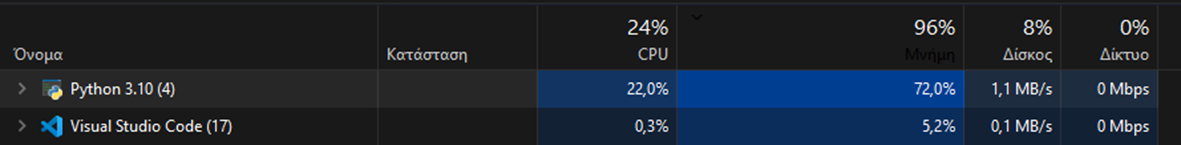



***---- Χρόνος ----***

Execution times
===============================================================
    1    4.082    4.082   11.544   11.544 bkp.py:101(calculate_jaccard_index)
    1    2.344    2.344    4.787    4.787 bkp.py:11(parse_categories_per_document)
    7    0.001    0.000    0.364    0.052 bkp.py:146(handle_command)
    2    0.003    0.002    0.360    0.180 bkp.py:187(show_top_k_stems_for_category)
    2    0.340    0.170    0.340    0.170 bkp.py:192(<dictcomp>)
    37107    0.004    0.000    0.004    0.000 bkp.py:195(<lambda>)
    2    0.000    0.000    0.000    0.000 bkp.py:198(<listcomp>)
    1    0.000    0.000    0.000    0.000 bkp.py:223(show_jaccard_index_for_pair)
    2    0.000    0.000    0.000    0.000 bkp.py:296(show_stems_or_categories_for_document)
    1    0.000    0.000    0.000    0.000 bkp.py:304(<listcomp>)
    2    0.000    0.000    0.000    0.000 bkp.py:309(count_terms_or_categories_for_document)
    8    0.000    0.000    0.018    0.002 bkp.py:321(menu)
    1    0.076    0.076    0.577    0.577 bkp.py:33(parse_terms_in_documents)
    1    0.000    0.000  487.152  487.152 bkp.py:342(main)
    14081    0.183    0.000    0.376    0.000 bkp.py:49(<listcomp>)
    1    0.041    0.041    0.061    0.061 bkp.py:55(parse_tid_to_stem)
    1    1.229    1.229    1.960    1.960 bkp.py:81(precompute_doc_sets)

    ***Από άλλη εκτέλεση***
    1    0.000    0.000  137.899  137.899 bkp.py:254(save_all_pairs) (json)
    1    2.067    2.067  544.516  544.516 bkp.py:254(save_all_pairs) (excel)


Από τα παραπάνω αποτελέσματα συμπαιρένουμε ότι:

Μνήμη: Στις συναρτήσεις parse_catergories_per_document, precompute_doc_sets, parse_tid_to_stem, calculate_jaccard_index παρατηρείτε μεγάλη αύξηση στην χρήση μνήμης καθώς αυτές εκτελούνε υπολογισμούς. Σε αυτό οφείλεται η αρχική καθυστέρηση του προγράμματος καθώς δημιουργούνται διάφορα dictionaries με δεδομένα όπως mappings και jaccard indexes. Το ίδιο παρατηρείται και στην save_all_pairs καθώς η μνήμη αυξάνεται πολύ στα σημεία που η μέθοδος δημιουργεί λίστα από dictionaries (json file) καθώς και στο for loop που κάνει append στο excel αρχείο.

Χρόνος:
Στο κομμάτι του χρόνου παρατηρούμε ότι το θέμα είναι κυρίως η συνάρτηση save_all_paris ειδικά στην δημιουργία excel αρχείου, ενώ ελάχιστα χρονοβόρα είνα η calculate_jaccard_index.


Προτάσεις:

Σε γενικές γραμμές το πρόγραμμα έχει καλούς χρόνους εκτέλεσης σε μεγάλο μέρος του αλλά είναι πολύ memory intensive. Για να το βελτιώσουμε αυτό θα μπορούσαμε:

Αρχικά για να βελτιώσουμε τον χρόνο εκκίνησης του προγράμματος θα μπορούσαμε να κάνουμε lazy loading, δηλαδή αντί για να κάνουμε υπολογισμούς στην αρχή, να υπολογίζουμε τα δεδομένα όταν αυτά ζητώνται. Παράλληλα θα μπορούσαμε να αποθηκεύσουμε τα δεδομένα που υπολογίσαμε μέχρι εκείνη την στιγμή. Αυτό είναι ιδανικό για το σενάριο που θέλουμε να αναζητήσουμε συχνά κάποια συγκεκριμένα δεδομένα, προσφέροντας γρήγορη αναζήτηση και ελάχιστη χρήση μνήμης (αντί να υπολογίσουμε και να αποθηκεύσουμε τα πάντα). Αυτό βέβαια απαιτεί αλλαγή στην δομή του κώδικα και θα είχε ως συνέπεια να αυξηθεί ο χρόνος των υπόλοιπων εντολών που μέχρι στιγμής είναι πολύ καλός (εφόσον και αν η τροποποίηση είναι εφικτή).

Επίσης θα μπορούσαν να γίνουν αλλαγές στις συναρτήσεις parse_catergories_per_document, precompute_doc_sets, parse_tid_to_stem, calculate_jaccard_index ώστε να μην υπάρχουν, όσο αυτό είναι εφικτό, nested loops και nested if statements για να καταφέρουμε καλύτερο χρόνο.

Όσον αφορά την save_all_pairs (το βασικό πρόβλημα του προγράμματος), θα μπορούσαμε:
A) νNα αποθηκεύουμε τα δεδομένα σε κομμάτια στα αρχεία (αντί να τα υπολογίσουμε όλα εκείνη την στιγμή και έπειτα να τα βάζουμε όλα μέσα στο αρχείο κατευθείαν). Αυτή η προσέγγιση θα ήταν πιο αποδοτική στο κομμάτι της μνήμης αλλά πιο αργή σε χρόνο εκτέλεσης λόγω περισσότερων disk accesses.(json file)

B)Ακόμη θα μπορούσαμε να γράφουμε τα δεδομένα κατευθείαν στην μνήμη καθώς αυτά υπολογίζονται.(json file)

C)Στο κομμάτι της save_all_pairs που δημιουργεί μπορούμε να ορίσουμε στην μέθοδο ότι θέλουμε να κάνουμε write_only. Με αυτό τον τρόπο εξοικονομούμε μνήμη και χρόνο καθώς η openpyxl δεν χρειάζεται να δημιουργήσει ένα full in-memory representation.(excel file) (https://openpyxl.readthedocs.io/en/latest/optimized.html)

# Refactoring Phase

## ⏩ Κώδικας Refactoring Phase

Γράψτε στο παρακάτω code cell όλο τον κώδικα του Aggregative News Analyzer σας αλλαγμένο (refactored) με βάση τα bottlenecks που εντοπίσατε στο profiling και διορθώσατε στο refactoring, καθώς και με βάση τις αρχές της Idomatic Python.

In [8]:
import json
from openpyxl import Workbook

#Execution time profiling part.
#Added cProfile to analyze execution time.
#We use cProfile.run() on main to get the execution time of all methods.
import cProfile

def parse_categories_per_document(filepath):
    """
    Parses the qrels file and returns a dictionary mapping each document ID to a list of categories.

    :param filepath: Path to the qrels file
    :return: Dictionary with document IDs as keys and lists of categories as values
    """

    categories_per_document = {}

    with open(filepath, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 3:
                category, document_id, _ = parts
                if document_id not in categories_per_document:
                    categories_per_document[document_id] = []
                categories_per_document[document_id].append(category)

    return categories_per_document

def parse_terms_in_documents(*filepaths):
    """
    Parses multiple vectors files and returns a dictionary mapping each document ID to a list of term IDs (ignoring weights).

    :param filepaths: Paths to the vectors files
    :return: Dictionary with document IDs as keys and lists of term IDs as values
    """
    categories_per_document = {}

    for filepath in filepaths:
        if not os.path.isfile(filepath):
            raise FileNotFoundError(f"The file '{filepath}' does not exist.")

        with open(filepath, 'r') as file:
            for line in file:
                try:
                    parts = line.strip().split()
                    if len(parts) == 3:
                        category, document_id, _ = parts
                        categories_per_document.setdefault(document_id, []).append(category)
                except ValueError as e:
                    print(f"Error processing line: {line}. {e}")

    return categories_per_document

def parse_tid_to_stem(filepath):
    """
    Parses the stem-term-idf map file and returns two dictionaries: one mapping term IDs to stems,
    and another mapping stems to term IDs (ignoring the idf values).

    :param filepath: Path to the stem-term-idf map file
    :return: Tuple of two dictionaries (term_id_to_stem, stem_to_term_id)
    """

    term_id_to_stem = {}
    stem_to_term_id = {}

    with open(filepath, 'r', encoding='ISO-8859-1') as file:
        # Skip the first two lines as they are junk data
        next(file)
        next(file)
        for line in file:
            parts = line.strip().split()
            if len(parts) == 3:
                stem, term_id, _ = parts
                term_id_to_stem[term_id] = stem
                stem_to_term_id[stem] = term_id

    return term_id_to_stem, stem_to_term_id

def precompute_doc_sets(terms_per_document, categories_per_document):
    # Precompute DOC(T)
    doc_per_term = {}
    for doc_id, term_ids in terms_per_document.items():
        for term_id in term_ids:
            if term_id not in doc_per_term:
                doc_per_term[term_id] = set()
            doc_per_term[term_id].add(doc_id)

    # Precompute DOC(C)
    doc_per_category = {}
    for doc_id, categories in categories_per_document.items():
        for category in categories:
            if category not in doc_per_category:
                doc_per_category[category] = set()
            doc_per_category[category].add(doc_id)

    return doc_per_term, doc_per_category

def calculate_jaccard_index(doc_per_term, doc_per_category):

    # Initialize Jaccard Index dictionary
    jaccard_index = {}
    # Calculate Jaccard Index without explicitly performing set operations
    for term_id, docs_with_term in doc_per_term.items():
        for category, docs_in_category in doc_per_category.items():
            intersection_size = len(docs_with_term.intersection(docs_in_category))
            union_size = len(docs_with_term) + len(docs_in_category) - intersection_size
            jaccard_index[(term_id, category)] = intersection_size / union_size if union_size else 0
    return jaccard_index

def handle_command(command, jaccard_index, term_id_to_stem_map, stem_to_term_id_map, parsed_terms_in_documents, parsed_categories_per_document):

    command_parts = command.split()
    command_type = command_parts[0]
    if command_type == "@":
        category = command_parts[1]
        k = int(command_parts[2])
        result = show_top_k_stems_for_category(category, k, jaccard_index, term_id_to_stem_map)
        print(result)
    elif command_type == "#":
        stem = command_parts[1]
        k = int(command_parts[2])
        result = show_top_k_categories_for_stem(stem,k,jaccard_index,stem_to_term_id_map)
        print(result)
    elif command_type == "$":
        stem = command_parts[1]
        category = command_parts[2]
        result = show_jaccard_index_for_pair(stem, category, jaccard_index, stem_to_term_id_map)
        print(result)

    elif command_type == "*":
        filename = command_parts[1].rsplit('.', 1)[0]  # Extract the filename without the extension
        filetype = command_parts[1].rsplit('.', 1)[1]  # Extract the extension as filetype
        save_all_pairs(filename, filetype, jaccard_index, term_id_to_stem_map)
        print(f"Data has been saved to {filename}.{filetype}")
    elif command_type == "P":
        doc_id = command_parts[1]
        switch = command_parts[2]
        result = show_stems_or_categories_for_document(doc_id, switch, parsed_terms_in_documents, parsed_categories_per_document, term_id_to_stem_map)
        print(result)

    elif command_type == "C":
        doc_id = command_parts[1]
        switch = command_parts[2]
        count = count_terms_or_categories_for_document(doc_id, switch, parsed_terms_in_documents, parsed_categories_per_document)
        print(count)

    else:
        return "Invalid command."

def show_top_k_stems_for_category(category, k, jaccard_index, term_id_to_stem_map):
    # Convert k to integer in case it's passed as a string
    k = int(k)

    # Filter Jaccard scores for the specified category
    category_scores = {term_id: score for (term_id, cat), score in jaccard_index.items() if cat == category}

    # Sort terms by Jaccard Index in descending order and get the top k
    top_k_terms = sorted(category_scores.items(), key=lambda item: item[1], reverse=True)[:k]

    # Convert term IDs to stems using the term_id_to_stem_map, handling cases where the term ID might not be in the map
    top_k_stems = [(term_id_to_stem_map.get(term_id, "unknown"), score) for term_id, score in top_k_terms]

    return top_k_stems

def show_top_k_categories_for_stem(stem, k, jaccard_index, stem_to_term_id):
    # Convert k to integer in case it's passed as a string
    k = int(k)

    # Retrieve the term_id for the given stem
    term_id = stem_to_term_id.get(stem)

    # If the stem is not found, return an empty list
    if not term_id:
        return []

    # Filter Jaccard scores for the specified term_id
    term_scores = {cat: score for (t_id, cat), score in jaccard_index.items() if t_id == term_id}

    # Sort categories by Jaccard Index in descending order and get the top k
    top_k_categories = sorted(term_scores.items(), key=lambda item: item[1], reverse=True)[:k]

    return top_k_categories

def show_jaccard_index_for_pair(stem, category, jaccard_index, stem_to_term_id_map):
    """
    Shows the Jaccard Index for a given (stem, category) pair.

    :param stem: The stem to look up.
    :param category: The category to look up.
    :param jaccard_index: The dictionary containing Jaccard Index scores.
    :param stem_to_term_id_map: The dictionary mapping stems to term IDs.
    :return: The Jaccard Index for the pair or a message if the pair is not found.
    """
    # Retrieve the term_id for the given stem
    term_id = stem_to_term_id_map.get(stem)

    # If the stem does not have a corresponding term_id, return a message
    if term_id is None:
        return f"No term ID found for stem '{stem}'."

    # Create the term-category pair tuple
    term_category_pair = (term_id, category)

    # Retrieve the Jaccard Index for the term-category pair
    jaccard_score = jaccard_index.get(term_category_pair)

    # If there is no Jaccard Index score for this pair, return a message
    if jaccard_score is None:
        return f"No Jaccard Index found for the pair ({stem}, {category})."

    # Return the Jaccard Index score
    return f"The Jaccard Index for the pair ({stem}, {category}) is {jaccard_score}."

#Modified.
    def save_all_pairs(filename, filetype, jaccard_index, term_id_to_stem_map):
        """
        Saves all (category, stem) pairs with their Jaccard Index in the specified file format.

        :param filename: The base name of the file to save.
        :param filetype: The type of the file to save ('json' or 'xlsx').
        :param jaccard_index: The dictionary containing Jaccard Index scores.
        :param term_id_to_stem_map: The dictionary mapping term IDs to stems.
        """
        if filetype == 'json':
            # Open the JSON file for writing
            with open(f'{filename}.json', 'w') as json_file:
                # Iterate through the Jaccard Index data and write each element to the file immediately
                for (term_id, category), score in jaccard_index.items():
                    data_to_save = {
                        "stem": term_id_to_stem_map.get(term_id),
                        "category": category,
                        "Jaccard Index": score
                    }
                    # Write the data to the JSON file
                    json.dump(data_to_save, json_file, indent=4)
                    # Add a newline character to separate entries in the JSON file
                    json_file.write('\n')

        elif filetype == 'xlsx':
            #We make the workbook write only for max efficiency.
            #changed from sheet=workbook.active to
            #sheet = workbook.create_sheet()
            #This change singificaly improves execution time.
            workbook = Workbook(write_only=True)
            sheet = workbook.create_sheet()
            sheet.title = 'Jaccard Indexes'
            
            # Add the column headers
            sheet.append(['Stem', 'Category', 'Jaccard Index'])
            
            # Add the Jaccard Index data to the worksheet
            for (term_id, category), score in jaccard_index.items():
                stem = term_id_to_stem_map.get(term_id)
                sheet.append([stem, category, score])

            # Save the workbook to an Excel file
            workbook.save(f'{filename}.xlsx')

def show_stems_or_categories_for_document(doc_id, switch, parsed_terms_in_documents, parsed_categories_per_document, term_id_to_stem_map):
    if switch == '-c':
        # Show all categories for the document
        categories = parsed_categories_per_document.get(doc_id, [])
        return categories
    elif switch == '-t':
        # Show all stems for the document
        term_ids = parsed_terms_in_documents.get(doc_id, [])
        return [term_id_to_stem_map.get(term_id, "unknown") for term_id in term_ids]
    else:
        raise ValueError("Invalid switch. Use '-c' for categories or '-t' for terms.")

def count_terms_or_categories_for_document(doc_id, switch, parsed_terms_in_documents, parsed_categories_per_document):
    if switch == '-c':
        # Count the number of unique categories for the document
        categories = parsed_categories_per_document.get(doc_id, [])
        return len(categories)
    elif switch == '-t':
        # Count the number of unique terms for the document
        terms = parsed_terms_in_documents.get(doc_id, [])
        return len(terms)
    else:
        raise ValueError("Invalid switch. Use '-c' for categories or '-t' for terms.")

def menu():
    print("-" * 100)
    print("    /|    / /                                // | |                                                           ")
    print("   //|   / /  ___                   ___     //__| |      __      ___     //          ___       ___      __    ")
    print("  // |  / / //___) ) //  / /  / / ((   ) ) / ___  |   //   ) ) //   ) ) // //   / /    / /   //___) ) //  ) )")
    print(" //  | / / //       //  / /  / /   \ \    //    | |  //   / / //   / / // ((___/ /    / /   //       //       ")
    print("//   |/ / ((____   ((__( (__/ / //   ) ) //     | | //   / / ((___( ( //      / /    / /__ ((____   //        ")
    print("-" * 100)
    print("COMMAND OPTIONS")
    print("-" * 50)
    print("@ <category> <k>                - Top k stems for a category")
    print("# <stem> <k>                    - Top k categories for a stem")
    print("$ <stem> <category>             - Jaccard index for stem-category pair")
    print("* <filename.extension>          - Save all pairs to a file")
    print("P <document_id> <-t/-c> - Stems/categories for a document")
    print("C <document_id> <-t/-c> - Count terms/categories in a document")
    print("-" * 50)
    print("Enter a command or type 'exit' to quit.")
    print("-" * 50)

def main():

    #parsed_terms_in_documents = parse_terms_in_documents('lyrl2004_vectors_train.dat.txt', 'lyrl2004_vectors_test_pt0.dat.txt', 'lyrl2004_vectors_test_pt1.dat.txt', 'lyrl2004_vectors_test_pt2.dat.txt', 'lyrl2004_vectors_test_pt3.dat.txt')
    parsed_terms_in_documents = parse_terms_in_documents('lyrl2004_vectors_train.dat.txt')
    parsed_categories_per_document = parse_categories_per_document('rcv1-v2.topics.qrels.txt')
    term_id_to_stem_map, stem_to_term_id_map = parse_tid_to_stem('stem.termid.idf.map.txt')

    doc_per_term, doc_per_category = precompute_doc_sets(parsed_terms_in_documents, parsed_categories_per_document)
    jaccard_index = calculate_jaccard_index(doc_per_term, doc_per_category)

    while True:
        try:
            menu()
            command = input("Enter command: ")
            if command == "exit":
                break
            else:
                handle_command(command, jaccard_index, term_id_to_stem_map, stem_to_term_id_map, parsed_terms_in_documents, parsed_categories_per_document)
        except Exception as e:
            print(f"An error occurred: {e}")



if __name__ == "__main__":
    cProfile.run(main())
"""**save_all_pairs**    
**Η συνάρτηση save_all_pairs σύμφωνα με το profiling άλλαξε ως εξής:    
    
    #Modified.
    def save_all_pairs(filename, filetype, jaccard_index, term_id_to_stem_map):
    
    if filetype == 'json':
        # Open the JSON file for writing
        with open(f'{filename}.json', 'w') as json_file:
            # Iterate through the Jaccard Index data and write each element to the file immediately
            for (term_id, category), score in jaccard_index.items():
                data_to_save = {
                    "stem": term_id_to_stem_map.get(term_id),
                    "category": category,
                    "Jaccard Index": score
                }
                # Write the data to the JSON file
                json.dump(data_to_save, json_file, indent=4)
                # Add a newline character to separate entries in the JSON file
                json_file.write('\n')

    elif filetype == 'xlsx':
        #We make the workbook write only for max efficiency.
        #changed from sheet=workbook.active to
        #sheet = workbook.create_sheet()
        #This change singificaly improves execution time.
        workbook = Workbook(write_only=True)
        sheet = workbook.create_sheet()
        sheet.title = 'Jaccard Indexes'
        
        # Add the column headers
        sheet.append(['Stem', 'Category', 'Jaccard Index'])
        
        # Add the Jaccard Index data to the worksheet
        for (term_id, category), score in jaccard_index.items():
            stem = term_id_to_stem_map.get(term_id)
            sheet.append([stem, category, score])

        # Save the workbook to an Excel 
        workbook.save(f'{filename}.xlsx')**"""


----------------------------------------------------------------------------------------------------
    /|    / /                                // | |                                                           
   //|   / /  ___                   ___     //__| |      __      ___     //          ___       ___      __    
  // |  / / //___) ) //  / /  / / ((   ) ) / ___  |   //   ) ) //   ) ) // //   / /    / /   //___) ) //  ) )
 //  | / / //       //  / /  / /   \ \    //    | |  //   / / //   / / // ((___/ /    / /   //       //       
//   |/ / ((____   ((__( (__/ / //   ) ) //     | | //   / / ((___( ( //      / /    / /__ ((____   //        
----------------------------------------------------------------------------------------------------
COMMAND OPTIONS
--------------------------------------------------
@ <category> <k>                - Top k stems for a category
# <stem> <k>                    - Top k categories for a stem
$ <stem> <category>             - Jaccard index for st

## ⏩ Τεκμηρίωση και Σχολιασμός Κώδικα της Refactoring Phase

Γράψτε στο παρακάτω text cell αναφορά που θα περιγράφετε τι κάνει ο κώδικας που αναπτύξατε στο Refactoring Phase και πως άλλαξε ώστε να γίνει πιο γρήγορος ή ώστε να καταναλώνει λιγότερη μνήμη ή να βρίσκει καλύτερο trade-off ανάμεσα σε αυτά τα δύο, με βάση τα συμπεράσματα της Profling Phase.

Αλλαγές:
1) Πλέον γράφουμε κατευθείνα στο json αρχείο το data καθώς αυτό το υπολογίζουμε.
2) Στο κομμάτι του excel ορίζουμε ότι το workbook είναι write_only.

Παρατηρούμε μεγάλη αλλαγή χρόνου και χρήση μνήμης αρχικά στο κομμάτι δημιουργίας του excel αρχείου (Απο 72% χρήση μνήμης, μόλις 26-27% και αντί για 500+ seconds, μόλις 200 seconds execution time) ενώ επίσης παρατηρείται χρήση λιγότερης μνήμης κατα την δημιουργία json αρχείου (απο 43% περίπου στα 27%) με αμελητέα διαφορά στο χρόνο.

Μετρήσεις:

New mem usage for excel creation.
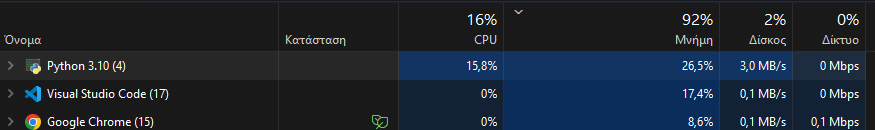

New time for excel creation:
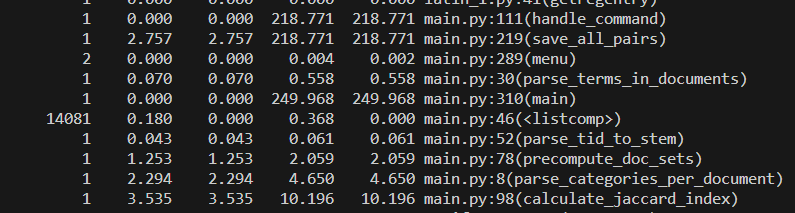

(Η μέτρηση που έγινε στο κομμάτι του profiling όσον αφορά την δημιουργία excel συγκεκριμένα είναι ενδεικτική και όχι πραγματική καθώς το πρόγραμμα έτρεχε υπερβολικά πολύ ώρα και έπρεπε να το σταματήσω με CTRL+C. Πλέον πράγματι ολοκληρώνει την δημιουργία του αρχείου και σε χρόνο ελάχιστα παραπάνω απο την δηιμουργία του json αρχείου)

**JSON file new mem usage**
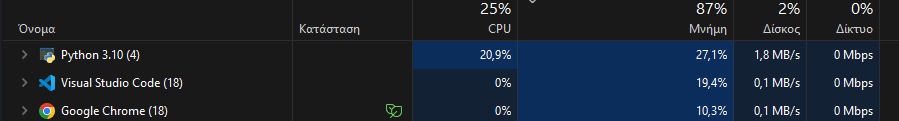

**vs old...**
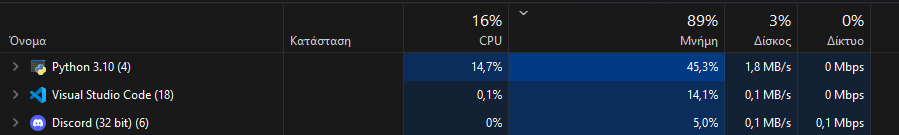

**new execution time for json**

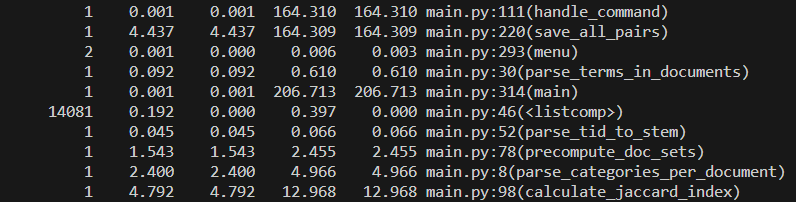